# Explore CT data and create DICOM images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
from glob import glob

from datetime import datetime

In [2]:
import SimpleITK as sitk # to write to dicom
import pydicom           # to read back and check dicom

print(f"pydicom: {pydicom.__version__}")
print(f"sitk:    {sitk.__version__}")

pydicom: 2.1.2
sitk:    2.0.2


In [3]:
start_time = datetime.now()

In [4]:
#!conda install opencv -c conda-forge

In [5]:
#conda install pydicom

In [6]:
#conda install -c simpleitk simpleitk

In [7]:
!ls ../data

COVID-19_Radiography_Dataset dicom_ct
COVID-CT-master              dicom_xray
ct_dataset.csv               xray_dataset.csv
ct_dataset_full.csv          xray_dataset_full.csv


In [8]:
!ls ../data/COVID-CT-master/Images-processed

CT_COVID        CT_COVID.zip    CT_NonCOVID     CT_NonCOVID.zip


## 1. Load the CT image dataset, define paths to the datasets, including path to COVID and Non-COVID data.

In [9]:
dir_covid  =  '../data/COVID-CT-master/Images-processed/CT_COVID'
dir_normal =  '../data/COVID-CT-master/Images-processed/CT_NonCOVID'

In [10]:
covid_files   = [dir_covid + '/' + x for x in os.listdir(dir_covid)]
nocovid_files = [dir_normal + '/' + x for x in os.listdir(dir_normal)]

print(f"covid: {len(covid_files)} + no_covid: {len(nocovid_files)}  = total: {len(covid_files)+len(nocovid_files)}")
print("COVID examples:\n",covid_files[:2])
print("Non COVID examples:\n",nocovid_files[:2])

covid: 349 + no_covid: 397  = total: 746
COVID examples:
 ['../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.01.20029769-p21-73_1%1.png', '../data/COVID-CT-master/Images-processed/CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png']
Non COVID examples:
 ['../data/COVID-CT-master/Images-processed/CT_NonCOVID/77.jpg', '../data/COVID-CT-master/Images-processed/CT_NonCOVID/412.png']


In [11]:
dict_all = {'file':covid_files+nocovid_files}

In [12]:
df = pd.DataFrame(dict_all,columns=['file'])
df['has_covid'] = df.apply(lambda x: 0 if 'CT_NonCOV' in x['file'] else 1, axis=1)
df.set_index(['file'],inplace=True)

In [13]:
# sanity check the counts
print(f"Total images: {df.shape[0]}")
cov_count = df['has_covid'].sum()
print(f"Covid images: {cov_count}    ...COVID fraction: {cov_count/df.shape[0]:.2}")

Total images: 746
Covid images: 349    ...COVID fraction: 0.47


In [14]:
df.head(3)

,has_covid
file,
../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.01.20029769-p21-73_1%1.png,1
../data/COVID-CT-master/Images-processed/CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png,1
../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.12.20034686-p17-91-4.png,1


In [15]:
df.tail(3)

,has_covid
file,
../data/COVID-CT-master/Images-processed/CT_NonCOVID/30%4.jpg,0
../data/COVID-CT-master/Images-processed/CT_NonCOVID/0.jpg,0
../data/COVID-CT-master/Images-processed/CT_NonCOVID/46.jpg,0


## 2. Open and display a random set of 9 images (COVID and non-COVID) from the CT image dataset.

In [16]:
covid_9 = np.random.choice(covid_files,9,replace=False)
nocovid_9 = np.random.choice(nocovid_files,9,replace=False)

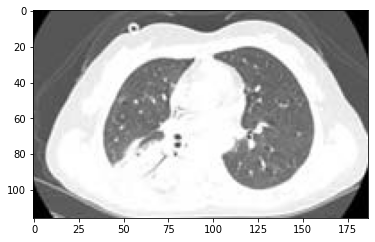

In [17]:
img=cv2.imread(covid_9[0])
plt.imshow(img)

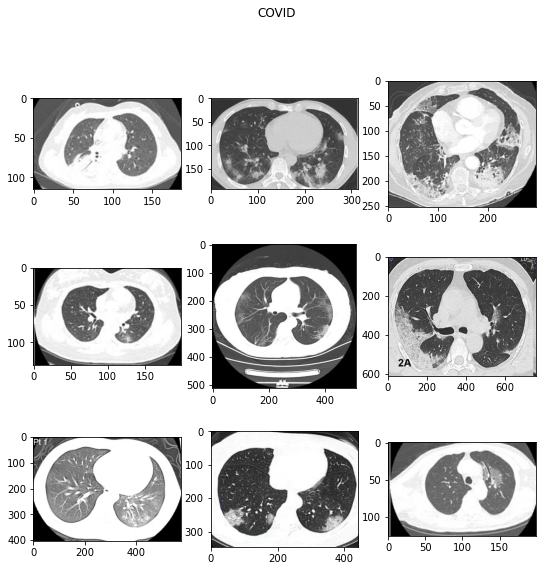

In [18]:
fig = plt.figure(figsize=(9,9))

axes = []
for idx,f in enumerate(covid_9):
    ax = fig.add_subplot(3,3,idx+1)
    axes.append(ax)
    img = cv2.imread(f)
    plt.imshow(img)
plt.suptitle('COVID');

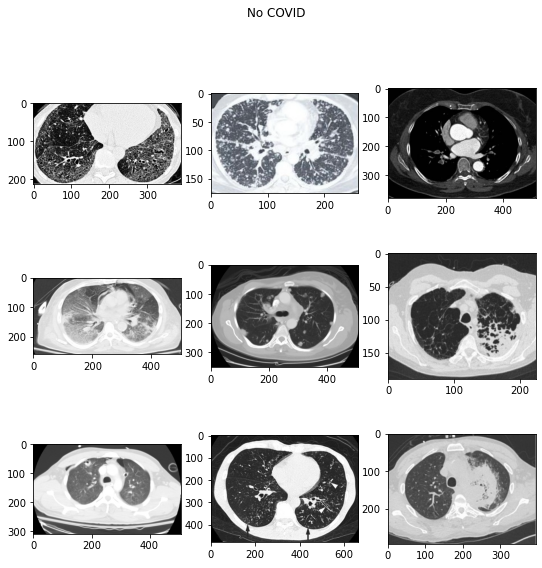

In [19]:
fig = plt.figure(figsize=(9,9))

axes = []
for idx,f in enumerate(nocovid_9):
    ax = fig.add_subplot(3,3,idx+1)
    axes.append(ax)
    img = cv2.imread(f)
    plt.imshow(img)
plt.suptitle('No COVID');

## 3. Resize all images to 224x224 pixels.

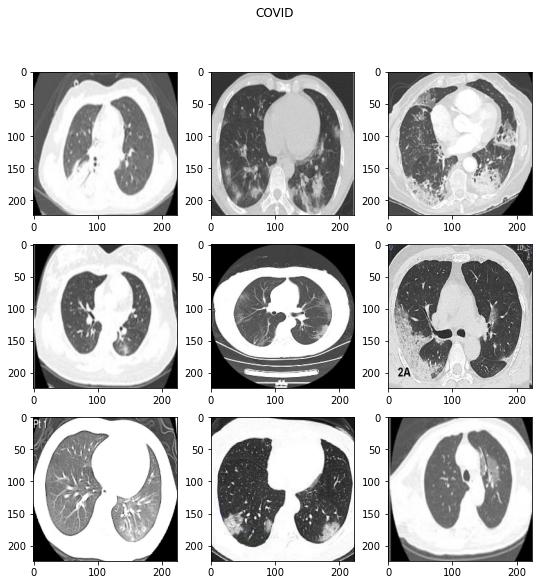

In [20]:
fig = plt.figure(figsize=(9,9))

axes = []
for idx,f in enumerate(covid_9):
    ax = fig.add_subplot(3,3,idx+1)
    axes.append(ax)
    img = cv2.imread(f)
    img2 = cv2.resize(img,(224,224))
    plt.imshow(img2)
plt.suptitle('COVID');

## 4. Plot label distribution of images- that is how many images per label for XRAY image dataset.

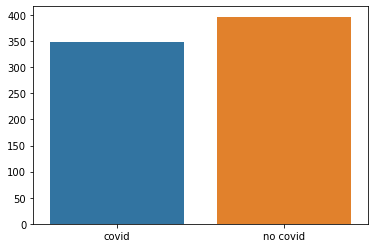

In [21]:
sns.barplot(x=['covid','no covid'], 
            y=[len(covid_files),len(nocovid_files)]);

## 5. Estimate image statistics- mean, max, min, standard deviation of pixel values in CT images.

In [22]:
def plot_9(flist,title):
    fig = plt.figure(figsize=(12,12))

    axes = []
    for idx,f in enumerate(covid_9):
        ax = fig.add_subplot(3,3,idx+1)
        axes.append(ax)
        img = cv2.imread(f)
        img2 = cv2.resize(img,(224,224))

        plt.imshow(img2)
        plt.title(f"min:{np.min(img2)} max:{np.max(img2)} mean:{int(np.mean(img2))} std:{int(np.std(img2))}")
    plt.suptitle(title);

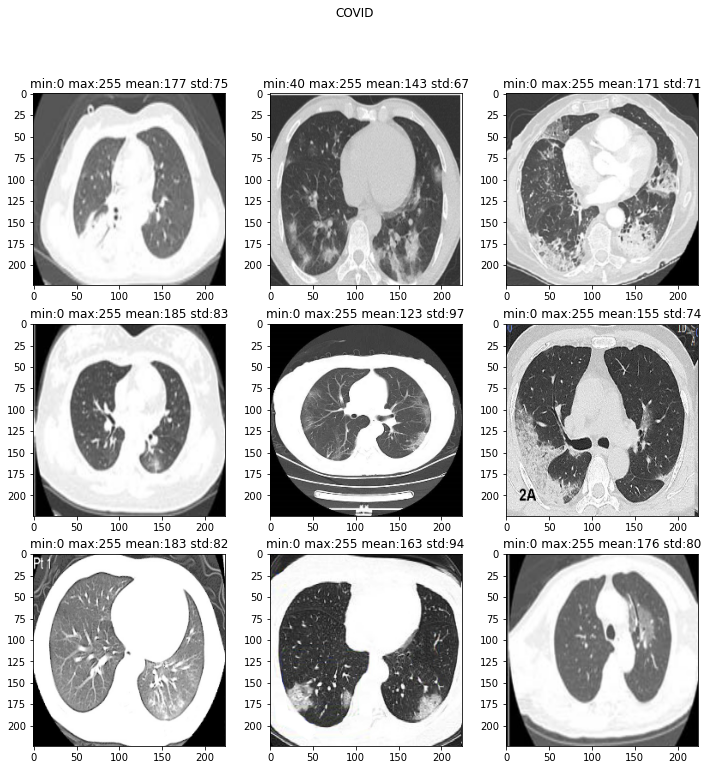

In [23]:
plot_9(covid_9,'COVID')

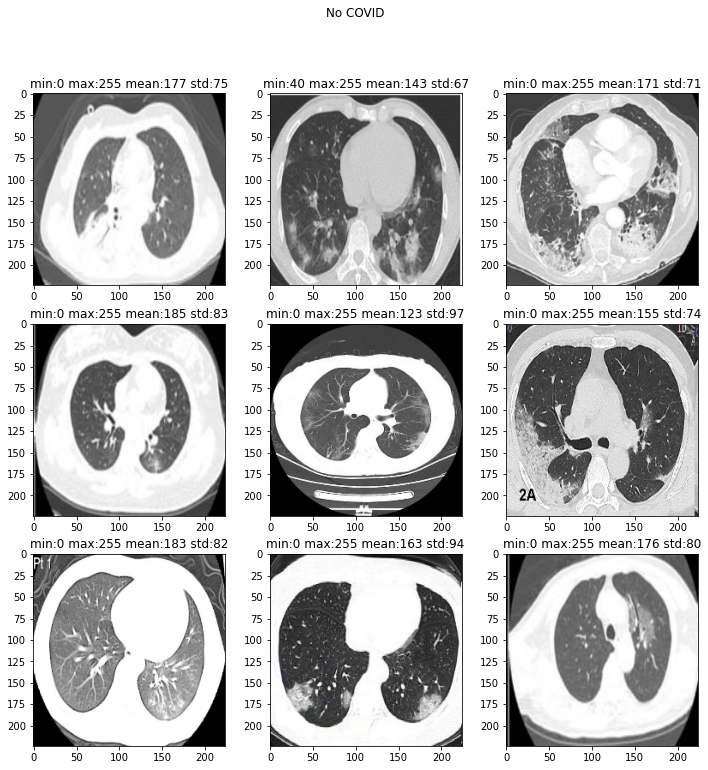

In [24]:
plot_9(nocovid_9,'No COVID')

## 6. Plot histogram of image intensities for COVID and Non-COVID images from the CT image dataset.

In [25]:
def plot_pair9_hist(flist,title):
    fig = plt.figure(figsize=(12,18))
    
    combined_hist = np.zeros((256,1))

    axes = []
    for idx,f in enumerate(flist):
        print(f"f is {f}")
        
        ax = fig.add_subplot(9,2,(2*idx)+1)
        axes.append(ax)
        img = cv2.imread(f)
        img2 = cv2.resize(img,(224,224))


        plt.imshow(img2)
        plt.title(f"min:{np.min(img2)} max:{np.max(img2)} mean:{int(np.mean(img2))} std:{int(np.std(img2))}")
        
        ax = fig.add_subplot(9,2,(2*idx)+2)
        img_hist = cv2.calcHist(img2,[0],None,[256],[0,256])
        combined_hist = combined_hist + img_hist
        plt.plot(img_hist)
    plt.suptitle(title);
    
    return combined_hist

f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.02.25.20021568-p23-108%8.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.10.20032136-p34-118_2%0.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/ehaa254-p0-63%2.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.02.25.20021568-p23-108%3.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.25.20037721-p27-182.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.03.20030775-p10-88%0.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.12.20034686-p17-91-5.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.22.20040782-p24-1533-2.png
f is ../data/COVID-CT-master/Images-processed/CT_COVID/2020.02.25.20021568-p23-108%2.png


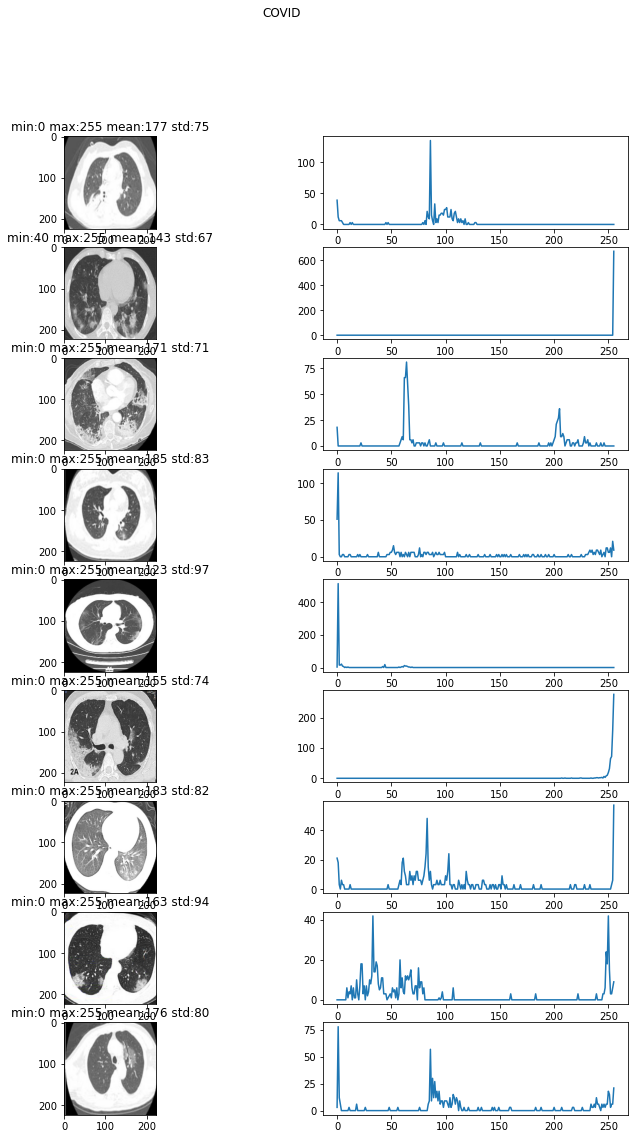

In [26]:
covid_hist = plot_pair9_hist(covid_9,'COVID')

f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/15%1.jpg
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/30%5.jpg
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/115.png
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/1309.png
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/1094.png
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/10%1.jpg
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/584.png
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/74.jpg
f is ../data/COVID-CT-master/Images-processed/CT_NonCOVID/60.jpg


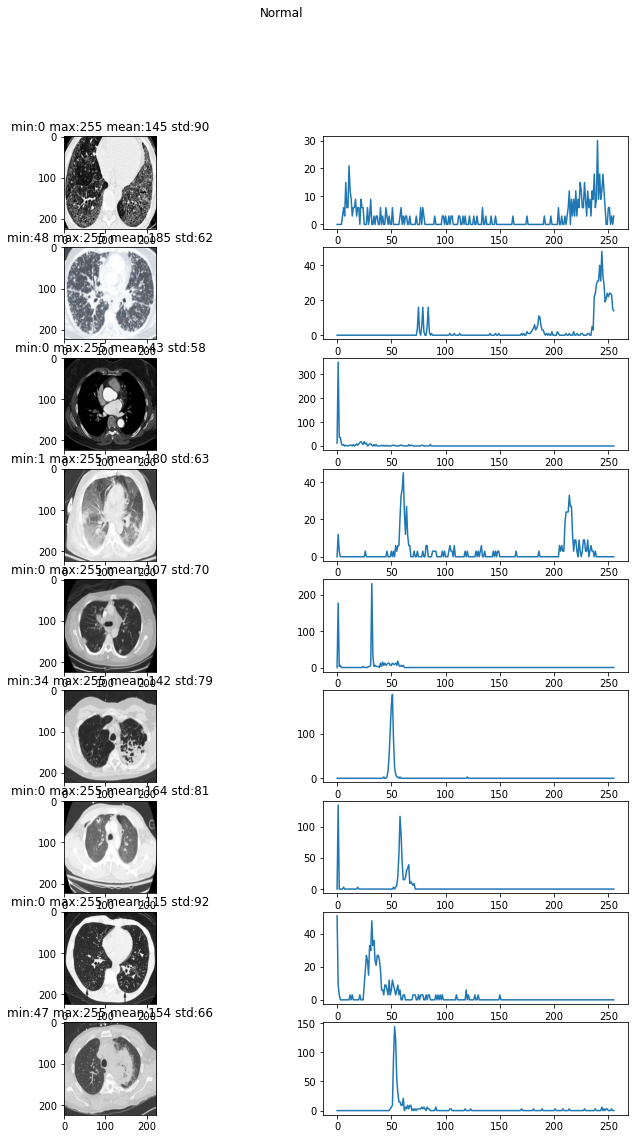

In [27]:
no_covid_hist = plot_pair9_hist(nocovid_9,'Normal')

## 7. Compare histograms of COVID and Non-COVID images. How do they differ? What information do you get from the histograms?


Individual histograms are difficult to use for drawing general conclusions. If I average 9 randomly selected histograms (those plotted above), then it looks like COVID patients have a larger number of mid-range pixels.

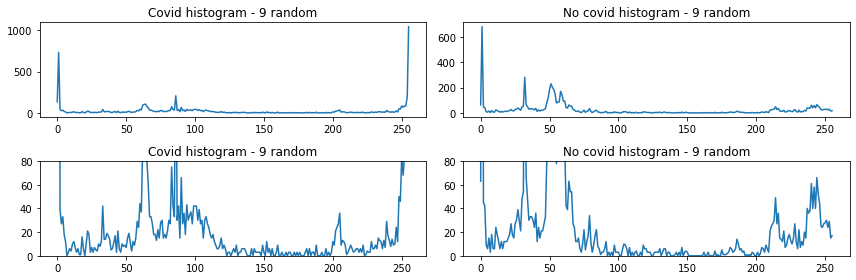

In [28]:
fig = plt.figure(figsize=(12,4))
# full scale versions show large spike at 0 (black pixels -- often the space around the body)
ax1 = fig.add_subplot(2,2,1)
plt.plot(covid_hist)
plt.title("Covid histogram - 9 random")
ax2 = fig.add_subplot(2,2,2)
plt.plot(no_covid_hist)
plt.title("No covid histogram - 9 random")

# zoom in on lower part of y axis
limit_y = 80
ax3 = fig.add_subplot(2,2,3)
plt.plot(covid_hist)
plt.title("Covid histogram - 9 random")
plt.ylim(0,limit_y)
ax4 = fig.add_subplot(2,2,4)
plt.plot(no_covid_hist)
plt.title("No covid histogram - 9 random")
plt.ylim(0,limit_y)

plt.tight_layout()

## 8. Convert all images from the COVID and Non-COVID directories in DICOM (.dcm) format.

### One way - pydicom

...but this would be very messy. I would need to open a blank image and stuff in the values in order for the data to be in the correct format.

In [29]:
covid_files[:2]

['../data/COVID-CT-master/Images-processed/CT_COVID/2020.03.01.20029769-p21-73_1%1.png',
 '../data/COVID-CT-master/Images-processed/CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png']

### Another way! - SimpleITK

Very interesting discovery! I didn't see this in any of the project resources, though, and had to go look at the solution to find it.

In [30]:
# Copied and adapted from the project solution "Project1_MS1_part1.ipynb"

def convert_to_dcm(file_list, index_start, destination_prefix):
    count = 0
    idx = index_start
    dict_name_pairs = dict()
    
    for image in file_list:
        im1 = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        #im1 = cv2.resize(im1,(224,224)) # unclear if this is needed -- project example didn't do this on export
        im1= np.array(im1)
        img= sitk.GetImageFromArray(im1)
        img = sitk.GetImageFromArray(im1)
        dicom_fname = destination_prefix + str(idx)+'.dcm'
        sitk.WriteImage(img, dicom_fname)
        idx = idx + 1
        count = count+1
        
        dict_name_pairs[image] = dicom_fname
    return count, idx, dict_name_pairs

### Covid examples

In [31]:
covid_count, total_covid, covid_pairs = convert_to_dcm(covid_files,0,'../data/dicom_ct/covid/covidchest_')   
print(f"{covid_count} images from the CT scan")
print(f"{total_covid} images in this folder")

349 images from the CT scan
349 images in this folder


### Non-covid examples

In [32]:
noncovid_count = 0 # use this for a running tally and to index everything sequentially

In [33]:
normal_count, noncovid_count, nocovid_pairs = convert_to_dcm(nocovid_files,noncovid_count,'../data/dicom_ct/no_covid/nocovidchest_')   
print(f"{normal_count} images from the non-covid CT scans")
print(f"{noncovid_count} images in this folder")

397 images from the non-covid CT scans
397 images in this folder


In [34]:
# Unclear if I'll want all of these types of non-covid images, but I'll start with this
print(f"Total COVID CTs: {covid_count}\n")

print(f"Total non-COVID CTs: {noncovid_count}\n")

Total COVID CTs: 349

Total non-COVID CTs: 397



### confirm valid dcm file

In [35]:
fpath = '../data/dicom_ct/no_covid/nocovidchest_0.dcm'
ds = pydicom.dcmread(fpath)

In [36]:
print(ds) # Discovered that I didn't convert images before export -- had to go back

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 254
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.71958527466665570602012863402227984
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.5.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.5'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 5.1.2'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.71958527466665570602012863402227984
(0008, 0020) Study Date                    

## 9. Save all file paths with their class labels to a CSV file.

### opt for new dataframe with full info

In [37]:
dict_all = {'file':covid_files + nocovid_files}
df2 = pd.DataFrame(dict_all,columns=['file'])
df2['has_covid'] = df2.apply(lambda x: 0 if 'CT_NonCOV' in x['file'] else 1, axis=1)

In [38]:
# sanity check
df2['has_covid'].sum()

349

In [39]:
df2.head(3)

,file,has_covid
0,../data/COVID-CT-master/Images-processed/CT_CO...,1
1,../data/COVID-CT-master/Images-processed/CT_CO...,1
2,../data/COVID-CT-master/Images-processed/CT_CO...,1


In [40]:
all_pairs = covid_pairs
all_pairs.update(nocovid_pairs)

In [41]:
df2['dcm_file'] = df2.apply(lambda x: all_pairs[x['file']], axis=1)

In [42]:
df2.head(3)

,file,has_covid,dcm_file
0,../data/COVID-CT-master/Images-processed/CT_CO...,1,../data/dicom_ct/covid/covidchest_0.dcm
1,../data/COVID-CT-master/Images-processed/CT_CO...,1,../data/dicom_ct/covid/covidchest_1.dcm
2,../data/COVID-CT-master/Images-processed/CT_CO...,1,../data/dicom_ct/covid/covidchest_2.dcm


In [43]:
df2.to_csv('../data/ct_dataset_full.csv',index=False)

### export a mini version to match the project example

In [44]:
df2[['dcm_file','has_covid']].to_csv('../data/ct_dataset.csv',index=False)

### note time

In [45]:
finish_time = datetime.now()
print(f"start:  {start_time}")
print(f"finish: {finish_time}")

start:  2021-05-31 09:53:13.675336
finish: 2021-05-31 09:53:22.817250
